# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [2]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [3]:
# TODO: load the air temperature and precipitation datasets.
# Example: air = xr.open_dataset(..., chunks={"time": 8})

air = xr.open_dataset(TEMP_URL, chunks={"time": 8})
precip = xr.open_dataset(PRECIP_URL, chunks={"time": 8})


## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [4]:
# I want to quickly check the names of the dimensions and see how
# the latitudes are ordered

print(air.dims)
print(precip.dims)
print(air['lon'])
print(air['lat'])
print(LON_RANGE_360)

FrozenMappingWarningOnValuesAccess({'time': 1464, 'lat': 73, 'lon': 144})
FrozenMappingWarningOnValuesAccess({'time': 366, 'lat': 360, 'lon': 720})
<xarray.DataArray 'lon' (lon: 144)> Size: 576B
array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,
        25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,
        50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,  72.5,
        75. ,  77.5,  80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5,
       100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5, 120. , 122.5,
       125. , 127.5, 130. , 132.5, 135. , 137.5, 140. , 142.5, 145. , 147.5,
       150. , 152.5, 155. , 157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5,
       175. , 177.5, 180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5,
       200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5,
       250. , 252.5, 255. , 257.5, 

In [5]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.
# Note: I had to flip the order of the latitudes

air_us = air.sel(lat=slice(50,20), lon=slice('LON_RANGE_360'), time=TIME_RANGE)
precip_us = precip.sel(lat=slice(50,20), lon=slice('LON_RANGE_360'), time=TIME_RANGE)

In [6]:
print(air_us)

<xarray.Dataset> Size: 900kB
Dimensions:  (time: 120, lat: 13, lon: 144)
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
Data variables:
    air      (time, lat, lon) float32 899kB dask.array<chunksize=(8, 13, 144), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimensi

In [7]:
print(air_us['air'])

<xarray.DataArray 'air' (time: 120, lat: 13, lon: 144)> Size: 899kB
dask.array<getitem, shape=(120, 13, 144), dtype=float32, chunksize=(8, 13, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]


In [8]:
print(precip_us['precip'])

<xarray.DataArray 'precip' (time: 30, lat: 60, lon: 720)> Size: 5MB
dask.array<getitem, shape=(30, 60, 720), dtype=float32, chunksize=(8, 60, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
Attributes:
    units:         mm
    var_desc:      Precipitation
    level_desc:    Surface
    statistic:     Total
    parent_stat:   Other
    long_name:     Daily total of precipitation
    cell_methods:  time: sum
    valid_range:   [   0. 1000.]
    avg_period:    0000-00-01 00:00:00
    actual_range:  [  0.   776.75]
    dataset:       CPC Global Precipitation
    _ChunkSizes:   [  1 360 720]


## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [9]:
# TODO: use xr.resample to create daily means.

air_daily = air_us.resample(time='1D').mean()
print(air_daily)

<xarray.Dataset> Size: 226kB
Dimensions:  (time: 30, lat: 13, lon: 144)
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
Data variables:
    air      (time, lat, lon) float32 225kB dask.array<chunksize=(1, 13, 144), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimens

## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [10]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.

air_interp = air_daily.interp(lat=precip_us.lat, lon=precip_us.lon)

## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [11]:
# TODO: build datasets and merge them into one object named `merged`.
# Need to rename the variables to match the next codeo block below
air_interp = air_interp.rename_vars({"air": "air_temperature"})
precip_us = precip_us.rename_vars({"precip": "daily_precip"})

merged = xr.merge([air_interp, precip_us])
print(merged)


<xarray.Dataset> Size: 10MB
Dimensions:          (time: 30, lat: 60, lon: 720)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
Data variables:
    air_temperature  (time, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 720), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 5MB dask.array<chunksize=(8, 60, 720), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5


## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [12]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)


<xarray.Dataset> Size: 10MB
Dimensions:          (time: 30, lat: 60, lon: 720)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
Data variables:
    air_temperature  (time, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 720), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 5MB dask.array<chunksize=(8, 60, 720), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


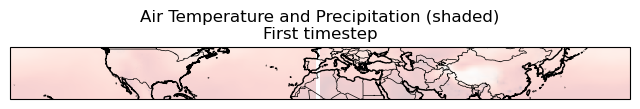

In [42]:
# Render both variables at the first timestep
first_step = merged.isel(time=0)

fig, ax = plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()})

precip_plot = ax.pcolormesh(first_step["lon"], first_step["lat"],
    first_step["daily_precip"],
    cmap="Blues", shading="auto", alpha=0.2)

temp_plot = ax.pcolormesh(first_step["lon"], first_step["lat"],
    first_step["air_temperature"],
    cmap="Reds", shading="auto", alpha=0.2)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title("Air Temperature and Precipitation (shaded)\nFirst timestep")

plt.show()

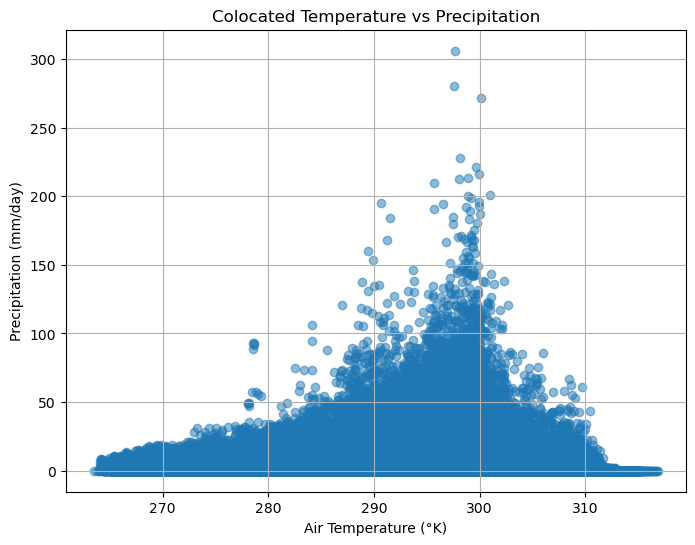

In [ ]:
# Build a scatter plot comparing temp and precip

stacked = merged.stack(points=("time", "lat", "lon"))

plt.figure(figsize=(8,6))
plt.scatter(stacked["air_temperature"], stacked["daily_precip"], alpha=0.5)
plt.xlabel("Air Temperature (°K)")
plt.ylabel("Precipitation (mm/day)")
plt.title("Colocated Temperature vs Precipitation")
plt.grid(True)
plt.show()

In [37]:
print(merged)

<xarray.Dataset> Size: 10MB
Dimensions:          (time: 30, lat: 60, lon: 720)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
Data variables:
    air_temperature  (time, lat, lon) float32 5MB dask.array<chunksize=(1, 60, 720), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 5MB dask.array<chunksize=(8, 60, 720), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5


In [ ]:
# Save the merged output for future analyses
if "_NCProperties" in merged.attrs:
    del merged.attrs["_NCProperties"]
# I had to add this command above because I kept getting an error saving the .nc file

merged.to_netcdf("merged_output.nc", mode="w")